# DCGAN on MNIST Digits dataset

Following the original GAN [1], Deep Convolutional Generative Adversarial Network (DCGAN) [2] is replacing some of the layers with convolutional layers.

The result is similar but taking advantage of the properties of the convolutional layers: less parameters to train, space invariance.

## Learning goals

- Starting from the GAN implementation notebook ([HTML](MNIST_GAN.html) / [Jupyter](MNIST_GAN.ipynb)), use convolutional layers


In [1]:
COLAB = True

if COLAB:
  from google.colab import drive
  drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install tensorview

In [3]:
import sys
import tensorflow as tf
import numpy as np
from tensorflow.keras import models, layers, losses, optimizers, metrics
import tensorflow_datasets as tf_ds
import tensorview as tv
import matplotlib.pyplot as plt
from pathlib import Path

/usr/local/lib/python3.6/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.2) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [4]:
if COLAB:
  model_path = Path('/content/drive/My Drive/Colab Notebooks/DsStepByStep')
else:
  model_path = Path('model')

In [5]:
batch_size = 200
latent_dim = 100
# Padding to 32x32 for better filtering by convo
image_width, image_height, image_channels = 32, 32, 1 
mnist_dim = image_width * image_height * image_channels

In [6]:
disc_learning_rate = 2e-4
gen_learning_rate  = 2e-4

relu_alpha = 0.001

# Data

MNIST dataset is optimized to be stored efficiently: images are closely cropped at 28x28 pixels and stored as 1 byte per pixel (uint8 format). However, to get proper performance we need to modify the input data to insert some padding around and convert the pixel format to float on 32 bits.

In [7]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32` and pad to 32 x 32"""
  image_float = tf.cast(image, tf.float32)/ 128. - 1.
  image_padded = tf.pad(image_float, [[0, 0], [2, 2], [2, 2], [0, 0]])
  return image_padded, label

(ds_train, ds_test) = tf_ds.load('mnist', split=['train', 'test'], batch_size=batch_size, as_supervised=True)
ds_train = ds_train.map(normalize_img)
#ds_train.batch(batch_size)
ds_train = ds_train.cache()

ds_test = ds_test.map(normalize_img)
#ds_test = ds_test.batch(batch_size)
ds_test = ds_test.cache()

ds_train, ds_test

(<CacheDataset shapes: ((None, 32, 32, 1), (None,)), types: (tf.float32, tf.int64)>,
 <CacheDataset shapes: ((None, 32, 32, 1), (None,)), types: (tf.float32, tf.int64)>)

# Models

GAN model is built out of a generator and a discriminator:
- The generator gets as input some random noise on space of 100 dimensions, and issues an image (32x32 pixel raster)
- The discriminator is trained to distinguish generated images by the generator (i.e. _fakes_), and reference images from the MNIST

The generator and discriminator architecture are more or less symmetrical. The generator is increasing the output space dimension step by step using upsampling layers after convolutional layers. The discriminator is similar to other classification networks reducing the input space dimensions down to the binary classification layer using strides on the convolutional layer. An alternative implementation of the generator is based on the transpose convolution whose stride is able to upsample.

The "game" is to jointly train the generator and discriminator in order to have the best generator but still being able to detect generated images.

In [8]:
generator = models.Sequential([
    layers.Dense(128 * 8 * 8, input_dim=latent_dim, name='g_1'),
    layers.LeakyReLU(relu_alpha),
    layers.Reshape((8, 8, 128)),
    layers.BatchNormalization(),
    layers.UpSampling2D((2, 2)),
    layers.Dropout(0.3),
    layers.Conv2D(64, kernel_size=(5, 5), padding="same", name='g_c1'),
    layers.LeakyReLU(relu_alpha),
    layers.BatchNormalization(),
    layers.UpSampling2D((2, 2)),
    layers.Conv2D(1, kernel_size=(5, 5), padding="same", activation='tanh', name='g_c2')
], name='generator')

generator.compile()
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
g_1 (Dense)                  (None, 8192)              827392    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 8192)              0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 128)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 8, 128)         512       
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 16, 16, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 128)       0         
_________________________________________________________________
g_c1 (Conv2D)                (None, 16, 16, 64)        20

In [9]:
discriminator = models.Sequential([
    layers.Conv2D(8, kernel_size=(5, 5), strides=(2, 2), padding="same", 
                  name='d_c1', input_shape=[32, 32, 1]),
    layers.LeakyReLU(relu_alpha),
    layers.Dropout(0.3),
    layers.Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding="same", name='d_c2'),
    layers.LeakyReLU(relu_alpha),
    layers.Flatten(),
    layers.Dense(1, name='d_1') # activation='sigmoid',
], name='discriminator')

discriminator.compile()
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
d_c1 (Conv2D)                (None, 16, 16, 8)         208       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 8)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 8)         0         
_________________________________________________________________
d_c2 (Conv2D)                (None, 8, 8, 64)          12864     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 8, 8, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
d_1 (Dense)                  (None, 1)               

# Training

Training is alternatively on the distriminator and generator.

The discriminator is trained on a batch made of half genuine images and half trained images.

The generator is trained with its output fed into the discriminator (whose wheights are frozen in this phase).

GAN reputation as difficult to be trained is well deserved and originates in the joint optimization which is similar to a minimax problem (min discrination error, max fidelity of the fakes). As seen below, the noise on the losses and accuracies is high. The main facilitators helping this training are:
- Use of leaky ReLU activations to avoid gradient vanishing
- Small learning rate to decrease the noise and instability
- Batch normalization layers to reduce variance at layer inputs

These are actually the recommendations of the DCGAN paper.


Due to the use of convolutional layers, and the small images at input, the number of trainable parameters of the discriminator is low. The number of parameters ot the generator is not that low since the dense layer is connected to all 100 inputs.

In [10]:
epochs = 60
batch_per_epoch = 60000/batch_size
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [11]:
def generator_loss(disc_generated_output):
    return loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

In [12]:
def discriminator_loss(disc_real_output, disc_generated_output):

    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    return real_loss + generated_loss

In [13]:
@tf.function
def train_step(generator, discriminator, 
               generator_optimizer, discriminator_optimizer, 
               generator_latent, batch, 
               epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        gen_latent = generator_latent()
        
        gen_output = generator(gen_latent, training=True)

        disc_real_output = discriminator(batch, training=True)
        disc_generated_output = discriminator(gen_output, training=True)

        gen_loss = generator_loss(disc_generated_output)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

        generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
        discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [14]:
generator_optimizer = tf.keras.optimizers.Adam(gen_learning_rate, beta_1=0.05)
discriminator_optimizer = tf.keras.optimizers.Adam(disc_learning_rate, beta_1=0.05)

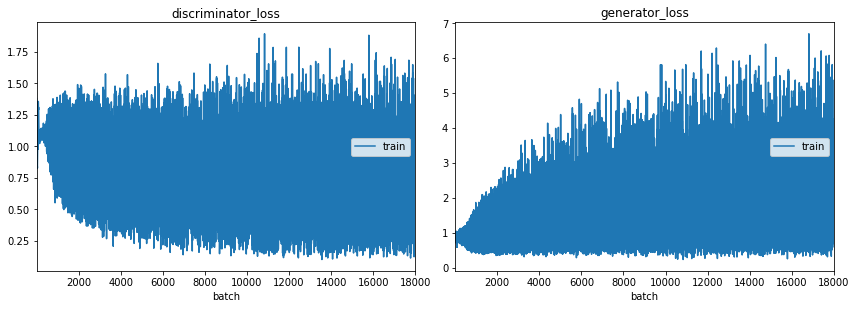

In [15]:
tv_plot = tv.train.PlotMetrics(wait_num=200, columns=2, iter_num=epochs * batch_per_epoch)

def generator_latent():
    return tf.random.normal((batch_size, latent_dim), 0, 1)

for epoch in range(epochs):

    for train_batch in iter(ds_train):
        
        g_loss, d_loss = train_step(generator, discriminator, 
                                    generator_optimizer, discriminator_optimizer, 
                                    generator_latent, train_batch[0], 
                                    epoch)
        # Plot
        tv_plot.update({ 'discriminator_loss': d_loss,# 'discriminator_acc': d_acc,
                        'generator_loss': g_loss, # 'generator_acc': g_acc
                       })
        tv_plot.draw()

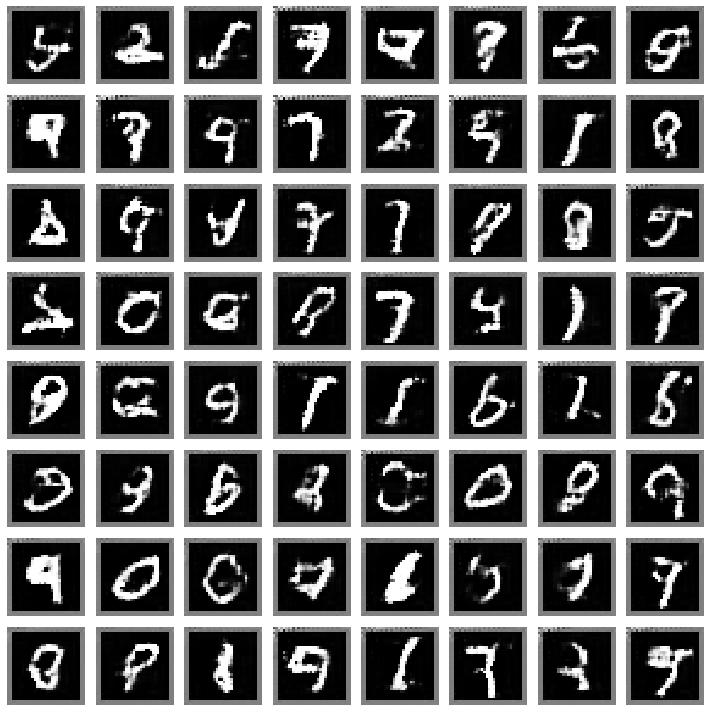

In [16]:
gen_latent = generator_latent()
gen_imgs = generator(gen_latent, training=True)
        
fig, axes = plt.subplots(8, 8, sharex=True, sharey=True, figsize=(10, 10))
for img, ax in zip(gen_imgs, axes.ravel()): # imgs.numpy()
    ax.imshow(img.numpy().reshape(image_width, image_height), interpolation='nearest', cmap='gray')
    ax.axis('off')
fig.tight_layout()

In [17]:
discriminator.save(model_path / 'mnist_dcgan_discriminator.h5')
generator.save(model_path / 'mnist_dcgan_generator.h5')

# Conclusion

Compared to the original GAN implementation, the disriminator accuracy is not sticking above 90%. The generator seems more able to create convincing fakes. But also the variance on the metrics is high. Visually, there is less noise on the background, digits are rounder. The straight digits like 7 and 1 seems harder to generate to this mode. And there are still some "ghosts" around the main shape.

## Where to go from here

- The original GAN based on dense layers ([HTML](MNIST_GAN.html) / [Jupyter](MNIST_GAN.ipynb))
- Revisit the fundamentals about deep neural networks in the CNN versus Dense classification ([HTML](../cnn/CnnVsDense-Part1.html) / [Jupyter](../cnn/CnnVsDense-Part1.jupyter) )

## References

1. ["Generative adversarial nets"](http://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf), I. Goodfellow, J. Pouget-Abadie, M. Mirza, B. Xu, D. Warde-Farley, S. Ozair, A. Courville, Y. Bengio, NIPS 2014
2. ["Unsupervised representation learning with deep convolutional generative adversarial networks"](https://arxiv.org/pdf/1511.06434.pdf), A. Radford, L. Metz, S. Chintala,
ICLR 2016